# 시계열 예측 - 자전거
- 선형 모델
- ARIMA
- prophet

In [ ]:
# !pip install fbprophet

In [1]:
from fbprophet import Prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 데이터 다운로드

In [3]:
bike = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/bike_train.csv", parse_dates=["datetime"])
print(bike.shape)
bike[:3]

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


## 자전거 대여수 (시계열 데이터)

In [4]:
df = bike[["datetime","count"]]
df[:3]

,datetime,count
0,2011-01-01 00:00:00,16
1,2011-01-01 01:00:00,40
2,2011-01-01 02:00:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  10886 non-null  datetime64[ns]
 1   count     10886 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 170.2 KB


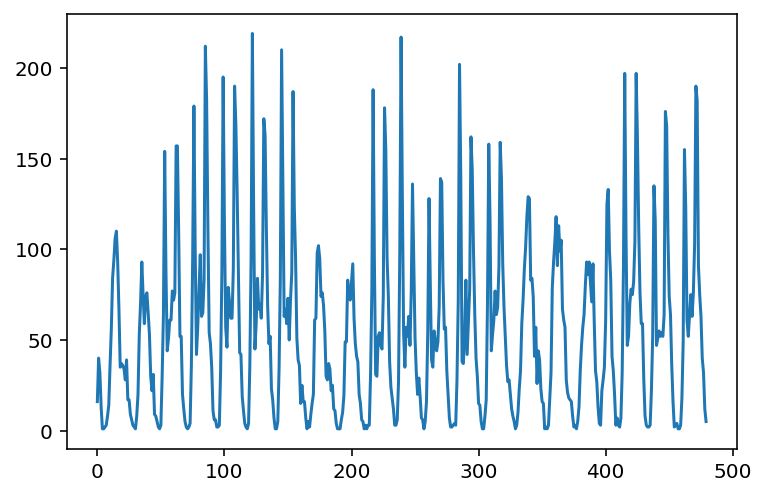

In [5]:
plt.plot(df["count"][:480])

In [16]:
# df["datetime"] = pd.to_datetime(df["datetime"])

## 시각화 함수

In [6]:
# 실제값과 예측치 비교
def plot_y_pred(y_test, y_pred):
    plt.figure(figsize=(8, 5))
    plt.plot(y_test, c='r')
    plt.plot(y_pred, c='b')
    plt.show()
    print("R2=", r2_score(y_test, y_pred).round(3))
    error = abs(y_test - y_pred)
    print("MAE=", error.mean().round(3))
    print("rmse=", np.sqrt((error**2).mean()).round(3))
    print("max=", max(error).round(3))

In [7]:
def scatter_errors(y_test, y_pred):
    error = abs(y_test - y_pred)
    plt.scatter(y_test, error, s=2)

# 선형 모델

In [8]:
count = df['count'].values

In [9]:
count.shape

(10886,)

In [10]:
count

array([ 16,  40,  32, ..., 168, 129,  88])

In [11]:
cut = np.int((len(count)*0.7))
train = count[:cut]
test = count[cut:]
train.shape, test.shape

((7620,), (3266,))

## 머신 러닝 모델에서 사용할 X, y 구조 생성

In [12]:
data = [1,2,3,4,5,6,7,8,9,10]
def split_seq_2(sequence, n_steps_in, n_steps_out=1):
  x, y = [],[]
  for i in range(len(sequence)):
    if i > len(sequence) - n_steps_in - n_steps_out: break
    x.append(sequence[i:i+n_steps_in])
    y.append(sequence[i+n_steps_in+n_steps_out-1])
  return np.array(x), np.array(y)

x, y = split_seq_2(data,4,2)
list(zip((x,y)))

[(array([[1, 2, 3, 4],
         [2, 3, 4, 5],
         [3, 4, 5, 6],
         [4, 5, 6, 7],
         [5, 6, 7, 8]]),),
 (array([ 6,  7,  8,  9, 10]),)]

## 적절한 n_steps_in 찾기

In [13]:
lr= LinearRegression()
n_steps_out = 1
for n_steps_in in range(1,24*30,24):
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_in, lr.score(x_test, y_test).round(3))

1 0.662
25 0.866
49 0.877
73 0.883
97 0.886
121 0.89
145 0.897
169 0.902
193 0.901
217 0.902
241 0.902
265 0.901
289 0.901
313 0.901
337 0.901
361 0.901
385 0.902
409 0.902
433 0.901
457 0.901
481 0.9
505 0.9
529 0.9
553 0.901
577 0.901
601 0.9
625 0.901
649 0.901
673 0.9
697 0.9


### 최적값 선택

168 0.901
0.901


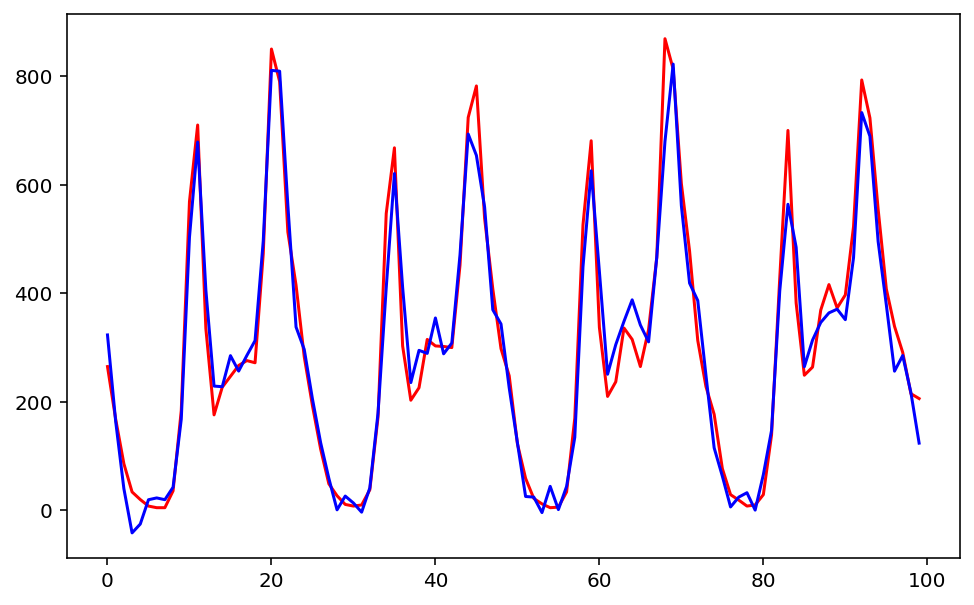

R2= 0.951
MAE= 38.532
rmse= 51.667
max= 189.149


In [14]:
n_steps_in = 7*24
n_steps_out = 1
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_in, lr.score(x_test, y_test).round(3))
y_pred = lr.predict(x_test)
print(r2_score(y_test, y_pred).round(3))
plot_y_pred(y_test[:100], y_pred[:100])

- 1시간 후를 예측했으므로 정확하다

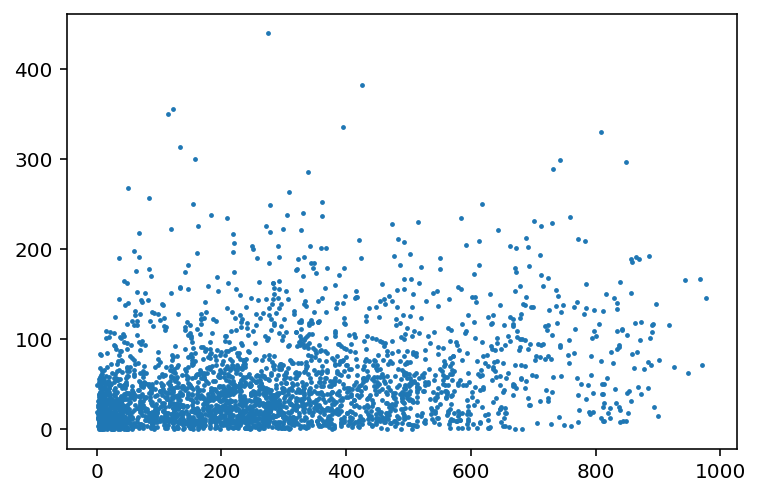

In [36]:
scatter_errors(y_test, y_pred)

## 미래 예측

In [15]:
lr = LinearRegression()
n_steps_in = 7*24
n_futures = [1, 5, 24, 24*7, 24*7*2, 24*7*3]
for n_steps_out in n_futures:
  x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
  x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
  lr.fit(x_train, y_train) 
  print(n_steps_out, ':', lr.score(x_test, y_test).round(3))

1 : 0.901
5 : 0.783
24 : 0.754
168 : 0.708
336 : 0.673
504 : 0.59


## 최적값 선택 in, out

In [16]:
n_steps_in = 24*7
n_steps_out= 24*7
x_train, y_train = split_seq_2(train, n_steps_in, n_steps_out)
x_test, y_test = split_seq_2(test, n_steps_in, n_steps_out)
lr.fit(x_train, y_train) 
print(n_steps_out, ',', lr.score(x_test, y_test).round(3))

168 , 0.708


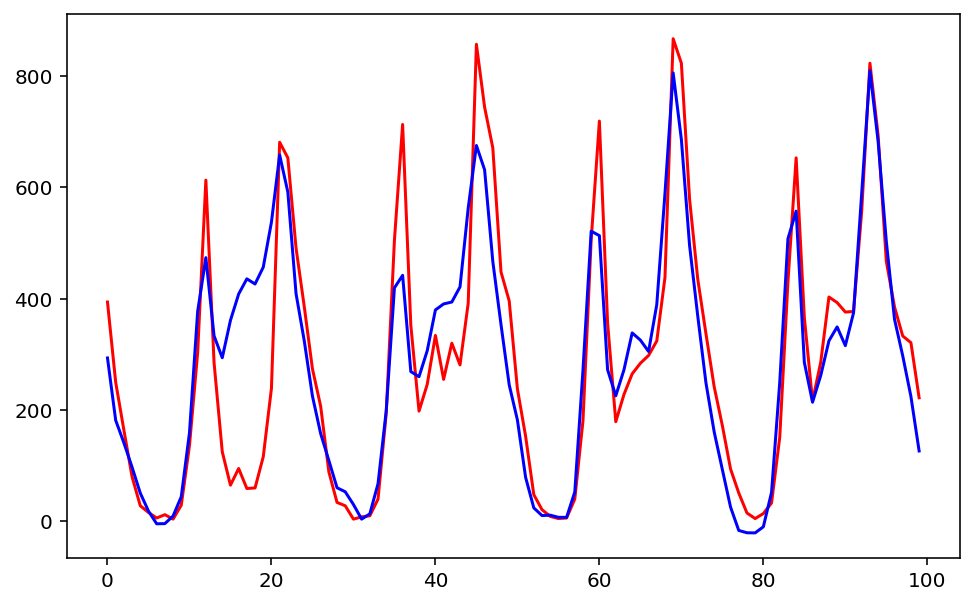

R2= 0.759
MAE= 78.125
rmse= 113.613
max= 376.634


In [17]:
y_pred = lr.predict(x_test)
plot_y_pred(y_test[:100], y_pred[:100])

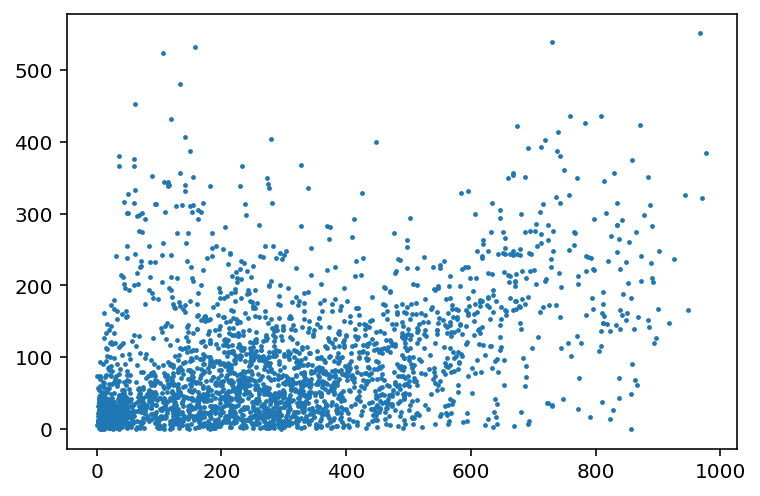

In [40]:
scatter_errors(y_test, y_pred)

# Prophet

In [18]:
df

,datetime,count
0,2011-01-01 00:00:00,16
1,2011-01-01 01:00:00,40
2,2011-01-01 02:00:00,32
3,2011-01-01 03:00:00,13
4,2011-01-01 04:00:00,1
...,...,...
10881,2012-12-19 19:00:00,336
10882,2012-12-19 20:00:00,241
10883,2012-12-19 21:00:00,168
10884,2012-12-19 22:00:00,129


In [19]:
df.columns = ['ds', 'y']
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [51]:
# model = Prophet()
# model.fit(df)

In [20]:
df['ds'].min(), df['ds'].max(), 

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [21]:
from datetime import datetime
from pandas import date_range

##  훈련 및 검증 

In [22]:
# cut = np.int((len(df)*0.7))
# test 기간 = 1 주일 (24*7)
train = df[:-24*7]
test = df[-24*7:]
train.shape, test.shape

((10718, 2), (168, 2))

In [23]:
future_test = test["ds"]
future_test[:3]

10718   2012-12-13 00:00:00
10719   2012-12-13 01:00:00
10720   2012-12-13 02:00:00
Name: ds, dtype: datetime64[ns]

In [24]:
model = Prophet()
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [25]:
future_test = pd.DataFrame(future_test)
future_test.columns = ['ds']
future_test[:3]

,ds
10718,2012-12-13 00:00:00
10719,2012-12-13 01:00:00
10720,2012-12-13 02:00:00


In [26]:
forecast = model.predict(future_test)
y_pred = forecast['yhat'].values
y_pred.shape

(168,)

In [28]:
y_test = test.y.values
y_test.shape

(168,)

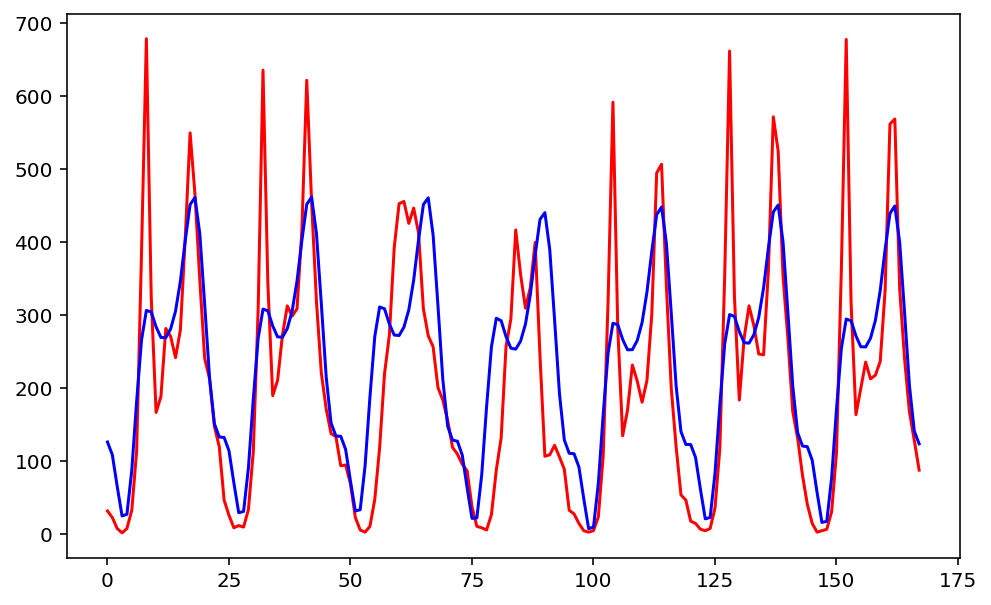

R2= 0.601
MAE= 76.722
rmse= 107.1
max= 383.06


In [29]:
plot_y_pred(y_test, y_pred)

## 향후 1개월 기간 예측

In [30]:
future = pd.date_range(start='2013-01-01', end='2013-01-20', 
                       freq='H').to_frame(index=False, name='ds')

In [31]:
future

,ds
0,2013-01-01 00:00:00
1,2013-01-01 01:00:00
2,2013-01-01 02:00:00
3,2013-01-01 03:00:00
4,2013-01-01 04:00:00
...,...
452,2013-01-19 20:00:00
453,2013-01-19 21:00:00
454,2013-01-19 22:00:00
455,2013-01-19 23:00:00


In [32]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01 00:00:00,117.935158,-21.383983,263.560226
1,2013-01-01 01:00:00,100.169715,-43.473988,236.020294
2,2013-01-01 02:00:00,56.798069,-85.834550,190.926001
3,2013-01-01 03:00:00,16.128398,-125.989459,145.832404
4,2013-01-01 04:00:00,18.066271,-135.509661,162.608229


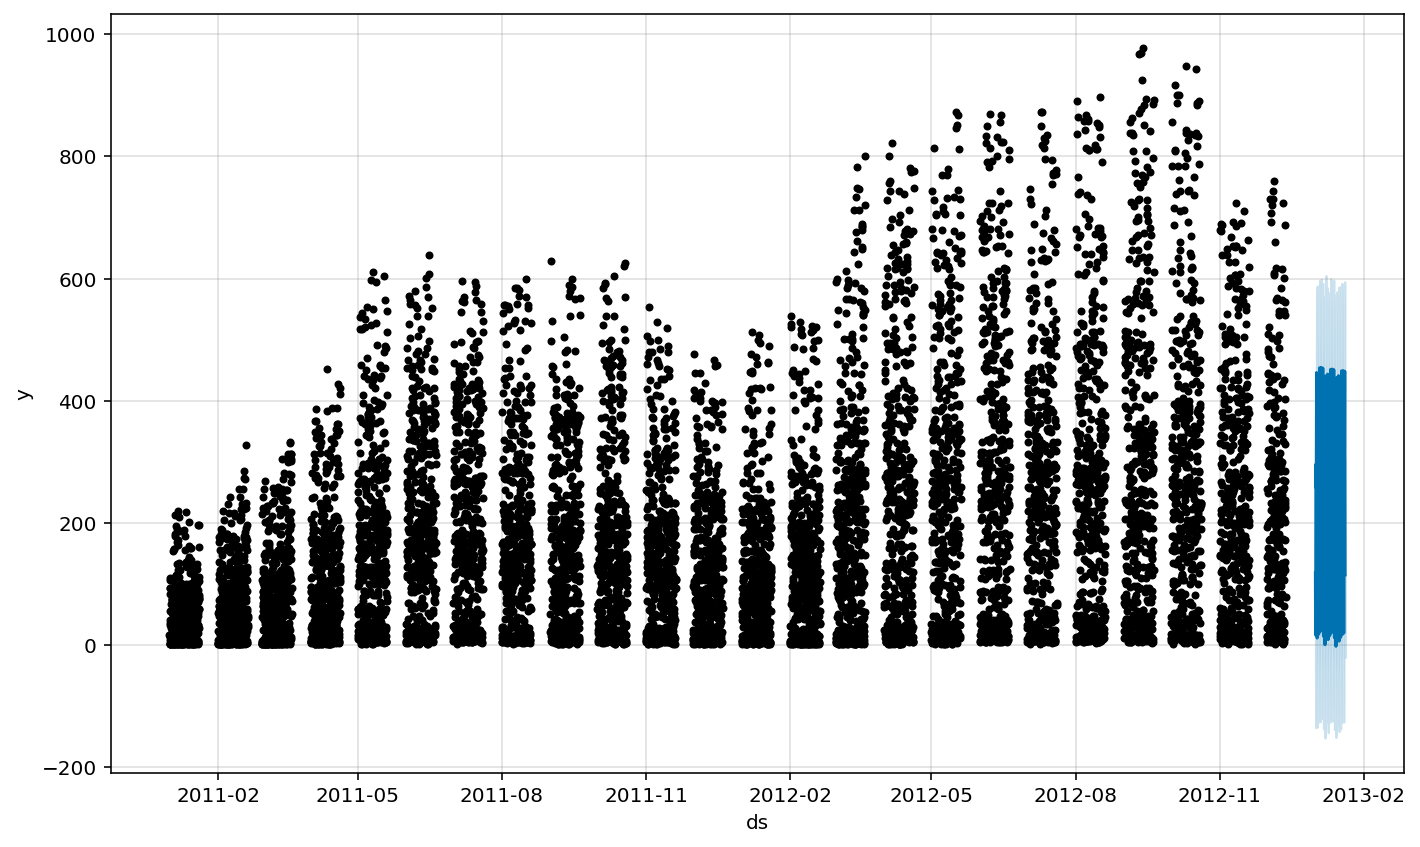

In [33]:
model.plot(forecast); plt.show()

In [61]:
# 1일 ~ 20일 데이터만 제공! 21 ~ 30 일 사이는 모두 결측치!

# Datetime  표시 (xtick)

In [193]:
import datetime
import matplotlib.dates as mdates
import matplotlib.units as munits

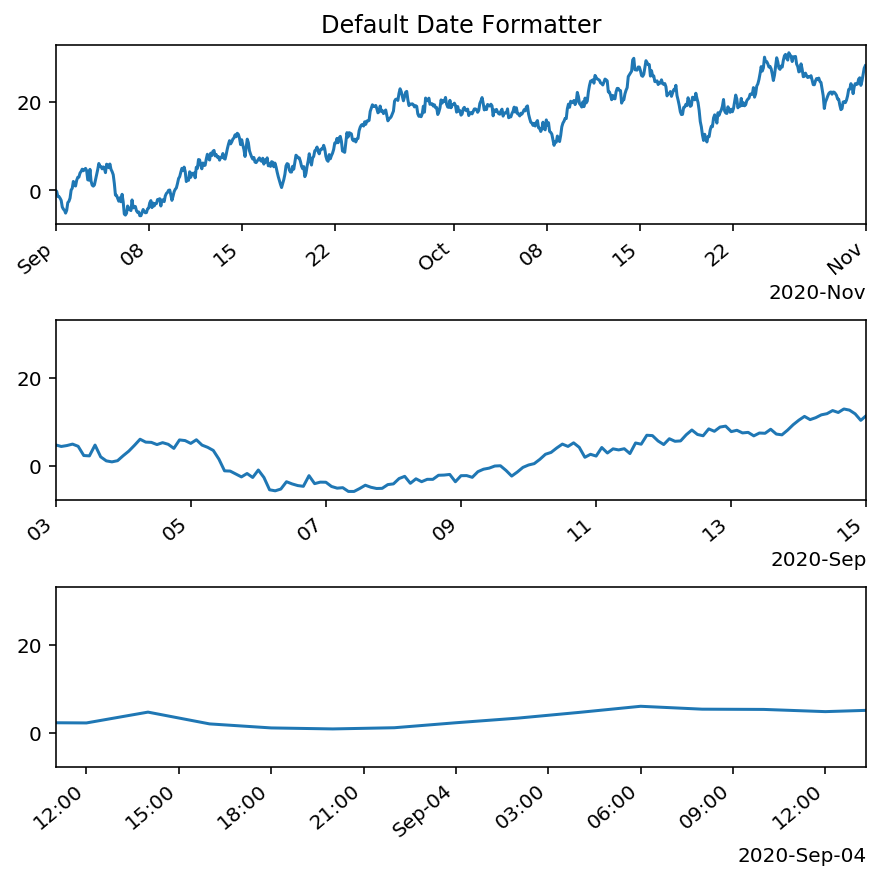

In [194]:
base = datetime.datetime(2020, 9, 1)
dates = np.array([base + datetime.timedelta(hours=(2 * i))
                  for i in range(732)])
N = len(dates)
np.random.seed(9)
y = np.cumsum(np.random.randn(N))

fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(6, 6))
lims = [(np.datetime64('2020-09'), np.datetime64('2020-11')),
        (np.datetime64('2020-09-03'), np.datetime64('2020-09-15')),
        (np.datetime64('2020-09-03 11:00'), np.datetime64('2020-09-04 13:20'))]
for nn, ax in enumerate(axs):
    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
    # rotate_labels...
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')
axs[0].set_title('Default Date Formatter')
plt.show()

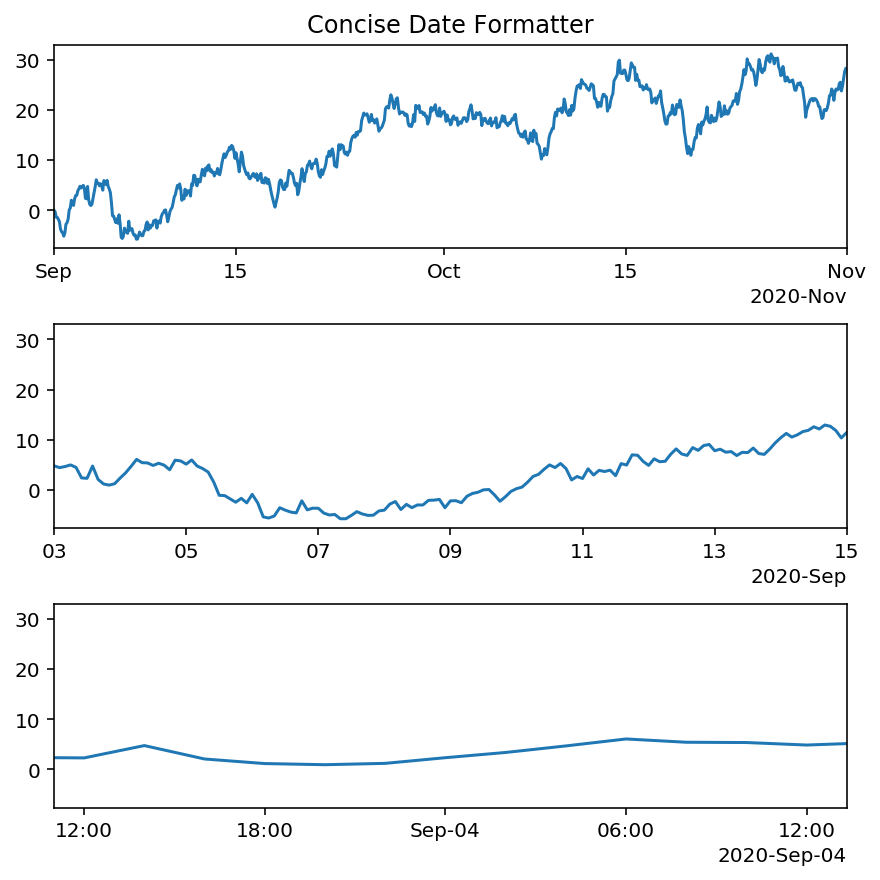

In [195]:
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(6, 6))
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
axs[0].set_title('Concise Date Formatter')
plt.show()

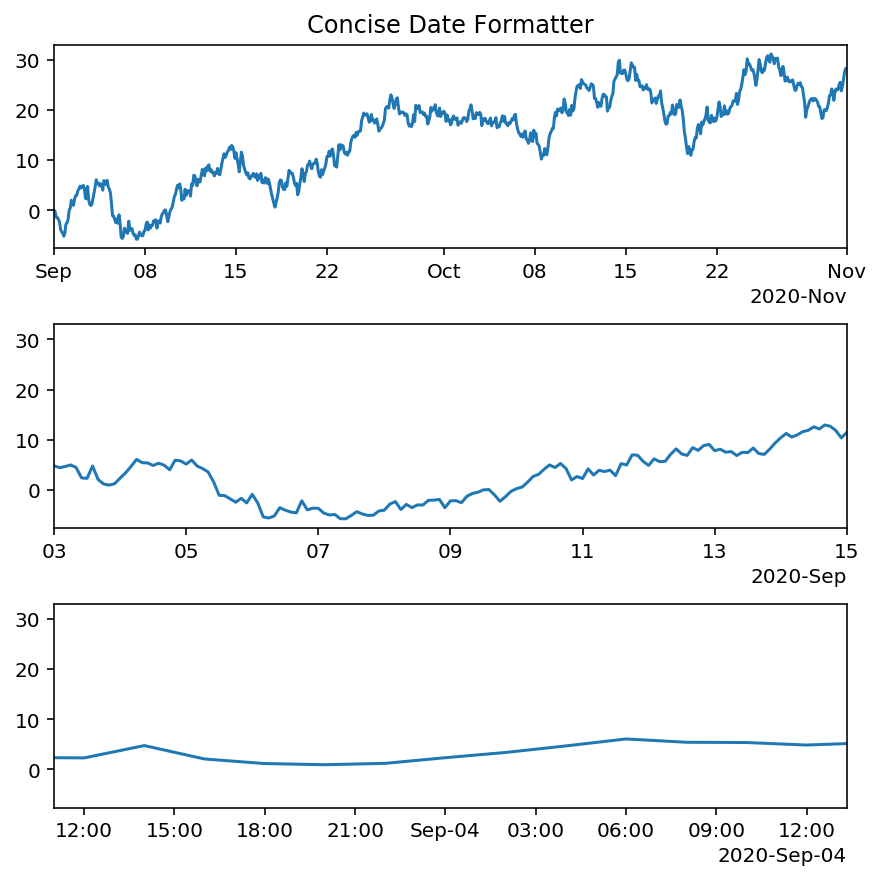

In [196]:
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

fig, axs = plt.subplots(3, 1, figsize=(6, 6), constrained_layout=True)
for nn, ax in enumerate(axs):
    ax.plot(dates, y)
    ax.set_xlim(lims[nn])
axs[0].set_title('Concise Date Formatter')

plt.show()